In [1]:
import os

# Because of the use of tf.image.ssim in the loss,
# this example requires TensorFlow. The rest of the code
# is backend-agnostic.
os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
from glob import glob
import matplotlib.pyplot as plt

import keras_hub
import tensorflow as tf
import keras
from keras import layers, ops

keras.config.disable_traceback_filtering()

2025-10-24 11:32:48.667825: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761298368.679216   16470 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761298368.682696   16470 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1761298368.692840   16470 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1761298368.692849   16470 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1761298368.692851   16470 computation_placer.cc:177] computation placer alr

In [12]:
IMAGE_SIZE = 288
BATCH_SIZE = 2
OUT_CLASSES = 1
TRAIN_SPLIT_RATIO = 0.90

In [13]:
data_dir = keras.utils.get_file(
    origin="http://saliencydetection.net/duts/download/DUTS-TE.zip",
    extract=True,
)
data_dir = os.path.join(data_dir, "DUTS-TE")


def load_paths(path, split_ratio):
    images = sorted(glob(os.path.join(path, "DUTS-TE-Image/*")))[:140]
    masks = sorted(glob(os.path.join(path, "DUTS-TE-Mask/*")))[:140]
    len_ = int(len(images) * split_ratio)
    return (images[:len_], masks[:len_]), (images[len_:], masks[len_:])


class Dataset(keras.utils.PyDataset):
    def __init__(
        self,
        image_paths,
        mask_paths,
        img_size,
        out_classes,
        batch,
        shuffle=True,
        **kwargs,
    ):
        if shuffle:
            perm = np.random.permutation(len(image_paths))
            image_paths = [image_paths[i] for i in perm]
            mask_paths = [mask_paths[i] for i in perm]
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.img_size = img_size
        self.out_classes = out_classes
        self.batch_size = batch
        super().__init__(*kwargs)

    def __len__(self):
        return len(self.image_paths) // self.batch_size

    def __getitem__(self, idx):
        batch_x, batch_y = [], []
        for i in range(idx * self.batch_size, (idx + 1) * self.batch_size):
            x, y = self.preprocess(
                self.image_paths[i],
                self.mask_paths[i],
                self.img_size,
            )
            batch_x.append(x)
            batch_y.append(y)
        batch_x = np.stack(batch_x, axis=0)
        batch_y = np.stack(batch_y, axis=0)
        return batch_x, batch_y

    def read_image(self, path, size, mode):
        x = keras.utils.load_img(path, target_size=size, color_mode=mode)
        x = keras.utils.img_to_array(x)
        x = (x / 255.0).astype(np.float32)
        return x

    def preprocess(self, x_batch, y_batch, img_size):
        images = self.read_image(x_batch, (img_size, img_size), mode="rgb")  # image
        masks = self.read_image(y_batch, (img_size, img_size), mode="grayscale")  # mask
        return images, masks


train_paths, val_paths = load_paths(data_dir, TRAIN_SPLIT_RATIO)

train_dataset = Dataset(
    train_paths[0], train_paths[1], IMAGE_SIZE, OUT_CLASSES, BATCH_SIZE, shuffle=True
)
val_dataset = Dataset(
    val_paths[0], val_paths[1], IMAGE_SIZE, OUT_CLASSES, BATCH_SIZE, shuffle=False
)

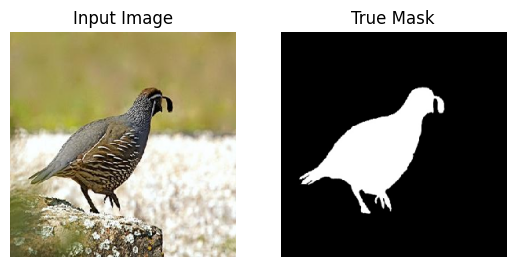

In [14]:
def display(display_list):
    title = ["Input Image", "True Mask", "Predicted Mask"]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(keras.utils.array_to_img(display_list[i]), cmap="gray")
        plt.axis("off")
    plt.show()


for image, mask in val_dataset:
    display([image[0], mask[0]])
    break

In [15]:
print(f"Unique values count: {len(np.unique((mask[0] * 255)))}")
print("Unique values:")
print(np.unique((mask[0] * 255)).astype(int))

Unique values count: 245
Unique values:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  61  62  63  65  66  67  68  69  70  71  73  74
  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 104 105 108 109 110 111 112
 113 114 115 116 117 118 119 120 122 123 124 125 128 129 130 131 132 133
 134 135 136 137 138 139 140 141 142 144 145 146 147 148 149 150 151 152
 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 170 171
 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 196 197 198 199 201 202 203 204 205 206 207 208
 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226
 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244
 245 246 24

In [16]:
def basic_block(x_input, filters, stride=1, down_sample=None, activation=None):
    """Creates a residual(identity) block with two 3*3 convolutions."""
    residual = x_input

    x = layers.Conv2D(filters, (3, 3), strides=stride, padding="same", use_bias=False)(
        x_input
    )
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(filters, (3, 3), strides=(1, 1), padding="same", use_bias=False)(
        x
    )
    x = layers.BatchNormalization()(x)

    if down_sample is not None:
        residual = down_sample

    x = layers.Add()([x, residual])

    if activation is not None:
        x = layers.Activation(activation)(x)

    return x


def convolution_block(x_input, filters, dilation=1):
    """Apply convolution + batch normalization + relu layer."""
    x = layers.Conv2D(filters, (3, 3), padding="same", dilation_rate=dilation)(x_input)
    x = layers.BatchNormalization()(x)
    return layers.Activation("relu")(x)


def segmentation_head(x_input, out_classes, final_size):
    """Map each decoder stage output to model output classes."""
    x = layers.Conv2D(out_classes, kernel_size=(3, 3), padding="same")(x_input)

    if final_size is not None:
        x = layers.Resizing(final_size[0], final_size[1])(x)

    return x


def get_resnet_block(resnet, block_num):
    """Extract and return a ResNet-34 block."""
    extractor_levels = ["P2", "P3", "P4", "P5"]
    num_blocks = resnet.stackwise_num_blocks
    if block_num == 0:
        x = resnet.get_layer("pool1_pool").output
    else:
        x = resnet.pyramid_outputs[extractor_levels[block_num - 1]]
    y = resnet.get_layer(f"stack{block_num}_block{num_blocks[block_num]-1}_add").output
    return keras.models.Model(
        inputs=x,
        outputs=y,
        name=f"resnet_block{block_num + 1}",
    )

In [17]:
def basnet_predict(input_shape, out_classes):
    """BASNet Prediction Module, it outputs coarse label map."""
    filters = 64
    num_stages = 6

    x_input = layers.Input(input_shape)

    # -------------Encoder--------------
    x = layers.Conv2D(filters, kernel_size=(3, 3), padding="same")(x_input)

    resnet = keras_hub.models.ResNetBackbone(
        input_conv_filters=[64],
        input_conv_kernel_sizes=[7],
        stackwise_num_filters=[64, 128, 256, 512],
        stackwise_num_blocks=[3, 4, 6, 3],
        stackwise_num_strides=[1, 2, 2, 2],
        block_type="basic_block",
    )

    encoder_blocks = []
    for i in range(num_stages):
        if i < 4:  # First four stages are adopted from ResNet-34 blocks.
            x = get_resnet_block(resnet, i)(x)
            encoder_blocks.append(x)
            x = layers.Activation("relu")(x)
        else:  # Last 2 stages consist of three basic resnet blocks.
            x = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(x)
            x = basic_block(x, filters=filters * 8, activation="relu")
            x = basic_block(x, filters=filters * 8, activation="relu")
            x = basic_block(x, filters=filters * 8, activation="relu")
            encoder_blocks.append(x)

    # -------------Bridge-------------
    x = convolution_block(x, filters=filters * 8, dilation=2)
    x = convolution_block(x, filters=filters * 8, dilation=2)
    x = convolution_block(x, filters=filters * 8, dilation=2)
    encoder_blocks.append(x)

    # -------------Decoder-------------
    decoder_blocks = []
    for i in reversed(range(num_stages)):
        if i != (num_stages - 1):  # Except first, scale other decoder stages.
            shape = x.shape
            x = layers.Resizing(shape[1] * 2, shape[2] * 2)(x)

        x = layers.concatenate([encoder_blocks[i], x], axis=-1)
        x = convolution_block(x, filters=filters * 8)
        x = convolution_block(x, filters=filters * 8)
        x = convolution_block(x, filters=filters * 8)
        decoder_blocks.append(x)

    decoder_blocks.reverse()  # Change order from last to first decoder stage.
    decoder_blocks.append(encoder_blocks[-1])  # Copy bridge to decoder.

    # -------------Side Outputs--------------
    decoder_blocks = [
        segmentation_head(decoder_block, out_classes, input_shape[:2])
        for decoder_block in decoder_blocks
    ]

    return keras.models.Model(inputs=x_input, outputs=decoder_blocks)

In [18]:
def basnet_rrm(base_model, out_classes):
    """BASNet Residual Refinement Module(RRM) module, output fine label map."""
    num_stages = 4
    filters = 64

    x_input = base_model.output[0]

    # -------------Encoder--------------
    x = layers.Conv2D(filters, kernel_size=(3, 3), padding="same")(x_input)

    encoder_blocks = []
    for _ in range(num_stages):
        x = convolution_block(x, filters=filters)
        encoder_blocks.append(x)
        x = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(x)

    # -------------Bridge--------------
    x = convolution_block(x, filters=filters)

    # -------------Decoder--------------
    for i in reversed(range(num_stages)):
        shape = x.shape
        x = layers.Resizing(shape[1] * 2, shape[2] * 2)(x)
        x = layers.concatenate([encoder_blocks[i], x], axis=-1)
        x = convolution_block(x, filters=filters)

    x = segmentation_head(x, out_classes, None)  # Segmentation head.

    # ------------- refined = coarse + residual
    x = layers.Add()([x_input, x])  # Add prediction + refinement output

    return keras.models.Model(inputs=[base_model.input], outputs=[x])

In [19]:
class BASNet(keras.Model):
    def __init__(self, input_shape, out_classes):
        """BASNet, it's a combination of two modules
        Prediction Module and Residual Refinement Module(RRM)."""

        # Prediction model.
        predict_model = basnet_predict(input_shape, out_classes)
        # Refinement model.
        refine_model = basnet_rrm(predict_model, out_classes)

        output = refine_model.outputs  # Combine outputs.
        output.extend(predict_model.output)

        # Activations.
        output = [layers.Activation("sigmoid")(x) for x in output]
        super().__init__(inputs=predict_model.input, outputs=output)

        self.smooth = 1.0e-9
        # Binary Cross Entropy loss.
        self.cross_entropy_loss = keras.losses.BinaryCrossentropy()
        # Structural Similarity Index value.
        self.ssim_value = tf.image.ssim
        # Jaccard / IoU loss.
        self.iou_value = self.calculate_iou

    def calculate_iou(
        self,
        y_true,
        y_pred,
    ):
        """Calculate intersection over union (IoU) between images."""
        intersection = ops.sum(ops.abs(y_true * y_pred), axis=[1, 2, 3])
        union = ops.sum(y_true, [1, 2, 3]) + ops.sum(y_pred, [1, 2, 3])
        union = union - intersection
        return ops.mean((intersection + self.smooth) / (union + self.smooth), axis=0)

    def compute_loss(self, x, y_true, y_pred, sample_weight=None, training=False):
        total = 0.0
        for y_pred_i in y_pred:  # y_pred = refine_model.outputs + predict_model.output
            cross_entropy_loss = self.cross_entropy_loss(y_true, y_pred_i)

            ssim_value = self.ssim_value(y_true, y_pred, max_val=1)
            ssim_loss = ops.mean(1 - ssim_value + self.smooth, axis=0)

            iou_value = self.iou_value(y_true, y_pred)
            iou_loss = 1 - iou_value

            # Add all three losses.
            total += cross_entropy_loss + ssim_loss + iou_loss
        return total

In [20]:
basnet_model = BASNet(
    input_shape=[IMAGE_SIZE, IMAGE_SIZE, 3], out_classes=OUT_CLASSES
)  # Create model.
basnet_model.summary()  # Show model summary.

optimizer = keras.optimizers.Adam(learning_rate=1e-4, epsilon=1e-8)
# Compile model.
basnet_model.compile(
    optimizer=optimizer,
    metrics=[keras.metrics.MeanAbsoluteError(name="mae") for _ in basnet_model.outputs],
)

Model: "bas_net_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 288, 288,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_52 (Conv2D)  │ (None, 288, 288,  │      1,792 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet_block1       │ (None, 288, 288,  │    222,720 │ conv2d_52[0][0]   │
│ (Functional)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_54       │ (None, 288, 288,  │          0 │ resnet_block1[0]… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet_block2       │ (None, 144, 144,  │  1,118,720 │ activation_54[0]… │
│ (Functional)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_55       │ (None, 144, 144,  │          0 │ resnet_block2[0]… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet_block3       │ (None, 72, 72,    │  6,829,056 │ activation_55[0]… │
│ (Functional)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_56       │ (None, 72, 72,    │          0 │ resnet_block3[0]… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet_block4       │ (None, 36, 36,    │ 13,121,536 │ activation_56[0]… │
│ (Functional)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_57       │ (None, 36, 36,    │          0 │ resnet_block4[0]… │
│ (Activation)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 18, 18,    │          0 │ activation_57[0]… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_53 (Conv2D)  │ (None, 18, 18,    │  2,359,296 │ max_pooling2d_6[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 18, 18,    │      2,048 │ conv2d_53[0][0]   │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_58       │ (None, 18, 18,    │          0 │ batch_normalizat… │
│ (Activation)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_54 (Conv2D)  │ (None, 18, 18,    │  2,359,296 │ activation_58[0]… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 18, 18,    │      2,048 │ conv2d_54[0][0]   │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 18, 18,    │          0 │ batch_normalizat

 Total params: 108,886,792 (415.37 MB)

 Trainable params: 108,834,952 (415.17 MB)

 Non-trainable params: 51,840 (202.50 KB)

In [21]:
basnet_model.fit(train_dataset, validation_data=val_dataset, epochs=1)

2025-10-24 11:37:22.506559: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=2} for conv %cudnn-conv-bias-activation.115 = (f32[2,512,9,9]{3,2,1,0}, u8[0]{0}) custom-call(f32[2,1024,9,9]{3,2,1,0} %bitcast.92231, f32[512,1024,3,3]{3,2,1,0} %bitcast.69890, f32[512]{0} %bitcast.92291), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="bas_net_1_1/conv2d_68_1/convolution" source_file="/home/xy/Desktop/ml/keras/test/keras_test/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-10-24 11:37:22.611547: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_

63/63 ━━━━━━━━━━━━━━━━━━━━ 226s 1s/step - activation_100_mae: 0.2160 - loss: 14.4430 - val_activation_100_mae: 0.6767 - val_loss: 224.6967


In [22]:
import gdown

gdown.download(id="1OWKouuAQ7XpXZbWA3mmxDPrFGW71Axrg", output="basnet_weights.h5")


def normalize_output(prediction):
    max_value = np.max(prediction)
    min_value = np.min(prediction)
    return (prediction - min_value) / (max_value - min_value)


# Load weights.
basnet_model.load_weights("./basnet_weights.h5")

Downloading...
From (original): https://drive.google.com/uc?id=1OWKouuAQ7XpXZbWA3mmxDPrFGW71Axrg
From (redirected): https://drive.google.com/uc?id=1OWKouuAQ7XpXZbWA3mmxDPrFGW71Axrg&confirm=t&uuid=b962cbb3-87d6-49a0-a828-562a14f46ba0
To: /home/xy/Desktop/ml/keras/test/basnet_weights.h5
100%|████████████████████████████████████████| 436M/436M [00:32<00:00, 13.2MB/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


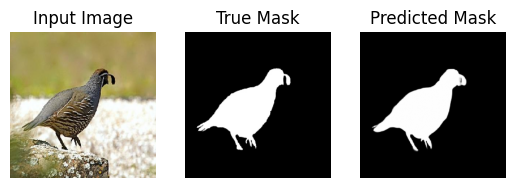

In [23]:
for (image, mask), _ in zip(val_dataset, range(1)):
    pred_mask = basnet_model.predict(image)
    display([image[0], mask[0], normalize_output(pred_mask[0][0])])